# 전라남도 인구데이터 전처리

### 사용 라이브러리

In [23]:
# 필요한 라이브러리 로드
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
sns.set_style()

## 개별/공동주택 데이터
사용된 데이터는 2024년 1월에 조회된 전라남도 내의 개별/공동주택 데이터다.

주택 데이터에서 각 지번에 위치한 주택의 총 면적을 추출하고자 한다.

In [24]:
# 필요한 컬럼만 추출
shared_cols = ['고유번호', '법정동코드', '법정동명', '지번', '특수지구분코드', '특수지구분명', '전용면적']
private_cols = ['고유번호', '법정동코드', '법정동명', '지번', '특수지구분코드', '특수지구분명', '건물산정연면적']

# 전남 주택가격정보 데이터 불러오기
raw_jeonnam_shared = pd.read_csv('./data/전남_공동주택가격정보.csv', encoding='cp949', usecols=shared_cols,
                                 dtype={'고유번호': object, '법정동코드': np.int64, '전용면적': np.float64})
raw_jeonnam_private = pd.read_csv('./data/전남_개별주택가격정보.csv', encoding='cp949', usecols=private_cols, 
                                  dtype={'고유번호': object, '법정동코드': np.int64, '건물산정연면적': np.float64})

### 주택 데이터 전처리 함수

In [25]:
def process_housing_data(df):
    """데이터프레임의 '법정동명'과 '지번' 컬럼을 합쳐 '주소' 컬럼을 만들고, '지번별 연면적'을 계산하는 함수"""
    
    # "지번" 컬럼에서 -를 기준으로 분리
    df['지번본번'] = df['지번'].str.split('-').str[0]
    
    # 법정동명과 지번을 합친 "주소" 컬럼을 만들어 반환
    df['주소'] = df['법정동명'] + ' ' + df['지번']
    
    # 지번별 총 연면적을 계산
    try:
        df['지번별 연면적'] = df.groupby(['주소'])['전용면적'].transform('sum')
        df = df.drop('전용면적', axis=1)
    except:
        df['지번별 연면적'] = df.groupby(['주소'])['건물산정연면적'].transform('sum')
        df = df.drop('건물산정연면적', axis=1)
    
    # 주소가 중복되는 행을 제거
    df = df.drop_duplicates(['주소'])
    
    # NaN 값이 있는 행을 제거
    df = df.dropna()
    
    return df

In [26]:
# 데이터 프레임 정리
df_housing_private = process_housing_data(raw_jeonnam_private)
df_housing_shared = process_housing_data(raw_jeonnam_shared)

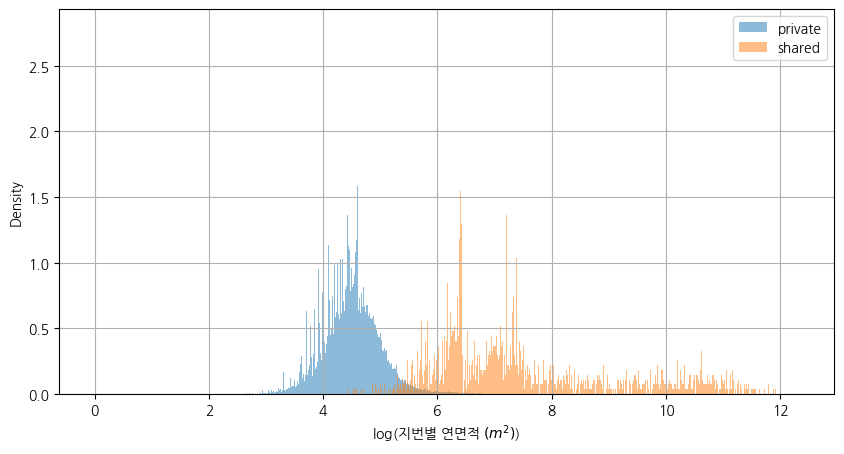

In [27]:
# 지번본번별 연면적 시각화, 분포 그래프로 확인
plt.figure(figsize=(10, 5))
plt.rc('font', family='NanumGothic')
plt.hist(df_housing_private['지번별 연면적'].apply(lambda x: np.log(x+1)), bins=1000, density=True, alpha=0.5, label='private')
plt.hist(df_housing_shared['지번별 연면적'].apply(lambda x: np.log(x+1)), bins=1000, density=True, alpha=0.5, label='shared')
plt.grid(True)
plt.xlabel('log(지번별 연면적 $(m^2)$)')
plt.ylabel('Density')
plt.legend()
plt.show()

---

In [28]:
# 전남 개별주택과 공동주택 데이터를 병합
df_housing = df_housing_private.merge(df_housing_shared, on=list(df_housing_private.columns[:-1]),
                                      how='outer', suffixes=('_private', '_shared'))

# 공동주택 데이터가 없는 경우 0으로 채움
df_housing.fillna(0, inplace=True)

In [29]:
# 총 지번별 연면적 계산
df_housing['지번별 연면적'] = df_housing['지번별 연면적_private'] + df_housing['지번별 연면적_shared']
df_housing.drop(['지번별 연면적_private', '지번별 연면적_shared'], axis=1, inplace=True)

In [30]:
df_housing.sample(5)

,고유번호,법정동코드,법정동명,특수지구분코드,특수지구분명,지번,지번본번,주소,지번별 연면적
91464,4617025022101210000,4617025022,전라남도 나주시 남평읍 대교리,1,일반,121,121,전라남도 나주시 남평읍 대교리 121,111.27
40030,4613014700100640004,4613014700,전라남도 여수시 묘도동,1,일반,64-4,64,전라남도 여수시 묘도동 64-4,55.00
197606,4678034027105180000,4678034027,전라남도 보성군 율어면 이동리,1,일반,518,518,전라남도 보성군 율어면 이동리 518,57.41
99448,4617036022101600001,4617036022,전라남도 나주시 다시면 월태리,1,일반,160-1,160,전라남도 나주시 다시면 월태리 160-1,75.80
103786,4617038030101230001,4617038030,전라남도 나주시 노안면 영평리,1,일반,123-1,123,전라남도 나주시 노안면 영평리 123-1,87.00


## 지번별 거주 인구수 추정
한국 전체 기준 1인당 평균 주거 면적이 2020년 기준 33.9 $m^2$ 이다.

지번 내의 총 면적을 33.9 $m^2$로 나누어 **지번별 추정 인구수**를 계산해 주도록 하겠다.

In [31]:
# 지번별 연면적을 1인당 평균 주거면적으로 나눔
df_housing['지번별 추정 인구수'] = (df_housing['지번별 연면적'] / 33.9)
df_housing[['지번별 연면적','지번별 추정 인구수']].describe()

,지번별 연면적,지번별 추정 인구수
count,388839.000000,388839.000000
mean,176.000262,5.191748
std,1880.314485,55.466504
min,0.000000,0.000000
25%,66.000000,1.946903
50%,89.340000,2.635398
75%,119.260000,3.517994
max,226185.570000,6672.140708


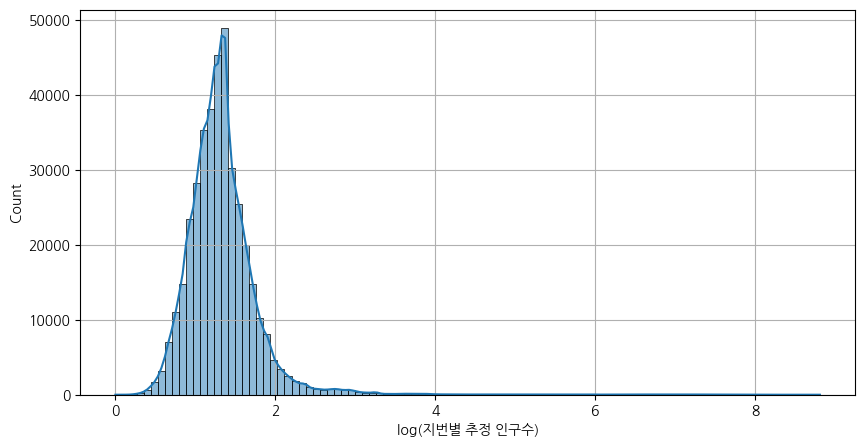

In [32]:
# 주소별 추정 인구수 분포를 log를 씌워 시각화
plt.figure(figsize=(10, 5))
plt.rc('font', family='NanumGothic')
sns.histplot(df_housing['지번별 추정 인구수'].apply(lambda x: np.log(x+1)), bins=100, kde=True)
plt.grid(True)
plt.xlabel('log(지번별 추정 인구수)')
plt.show()

---

## 전라남도 인구 데이터 전처리
전라남도의 각 법정동 별 총인구수랑 70세이상 인구 비율을 추출해준다.

In [33]:
# 총 읍면동 별 인구 데이터 불러오기
raw_pop = pd.read_csv('./data/전국_202401_70세_이상_인구통계_법정동.csv', encoding='utf-8-sig')
raw_pop.columns

Index(['법정동코드', '기준연월', '시도명', '시군구명', '읍면동명', '리명', '계', '남자', '여자', '0세남자',
       ...
       '101세여자', '102세여자', '103세여자', '104세여자', '105세여자', '106세여자', '107세여자',
       '108세여자', '109세여자', '110세이상 여자'],
      dtype='object', length=231)

### 필요한 컬럼/행 추출

In [34]:
# 전남 데이터만 추출
raw_pop = raw_pop[raw_pop['시도명'].str.contains('전라남도')]

# 70세 이상 남, 녀, 총 데이터만 추출
raw_pop['70세이상 남자'] = raw_pop.loc[:,'70세남자':'110세이상 남자'].sum(axis=1)
raw_pop['70세이상 여자'] = raw_pop.loc[:,'70세여자':'110세이상 여자'].sum(axis=1)
raw_pop['70세이상 계'] = raw_pop['70세이상 남자'] + raw_pop['70세이상 여자']

# 필요한 열들만 추출
interested_columns = ['법정동코드', '시도명', '시군구명', '읍면동명', '리명', '계', '70세이상 계']

# 전남 데이터프레임 생성
df_pop = raw_pop[interested_columns]

### 70세이상 인구비율 계산

In [35]:
# 70세 이상 인구 비율 계산
df_pop['70세이상 인구비율'] = df_pop['70세이상 계'] / df_pop['계'] * 100

지금의 데이터는 읍면동-리 까지 구분이 되어있기 때문에, 동일한 기준 적용을 위해 읍면동까지만 구분된 인구 데이터도 계산해 준다.

In [36]:
# 읍면동 기준의 총인구 및 70세이상 인구 계산
df_pop[['읍면동 총인구', '읍면동 70세이상 인구']] = df_pop.groupby(['시도명', '시군구명', '읍면동명'])[['계', '70세이상 계']].transform('sum')

In [37]:
# 컬럼명 변환
df_pop.columns = ['법정동코드', '시도명', '시군구명', '읍면동명', '리명', 
                  '읍면동리 총인구', '읍면동리 70세이상 인구', '읍면동리 70세이상 인구비율',
                  '읍면동 총인구', '읍면동 70세이상 인구']

# 최종 데이터프레임 확인
df_pop.head()

,법정동코드,시도명,시군구명,읍면동명,리명,읍면동리 총인구,읍면동리 70세이상 인구,읍면동리 70세이상 인구비율,읍면동 총인구,읍면동 70세이상 인구
7569,4611010100,전라남도,목포시,용당동,용당동,12477,3024,24.236595,12477,3024
7570,4611010200,전라남도,목포시,산정동,산정동,41280,7389,17.899709,41280,7389
7571,4611010300,전라남도,목포시,연산동,연산동,13039,1129,8.658639,13039,1129
7572,4611010400,전라남도,목포시,대성동,대성동,3899,525,13.464991,3899,525
7573,4611010500,전라남도,목포시,양동,양동,1318,365,27.693475,1318,365


---

## 인구 + 지번별 면적/추정인구 데이터 병합

In [38]:
# 법정동코드를 기준으로 데이터를 병합
df_merged = pd.merge(df_housing.drop(['법정동명', '지번본번', '특수지구분코드', '특수지구분명'], axis=1),
                    df_pop, on='법정동코드', how='left')
df_merged.head()

,고유번호,법정동코드,지번,주소,지번별 연면적,지번별 추정 인구수,시도명,시군구명,읍면동명,리명,읍면동리 총인구,읍면동리 70세이상 인구,읍면동리 70세이상 인구비율,읍면동 총인구,읍면동 70세이상 인구
0,4611010100101710003,4611010100,171-3,전라남도 목포시 용당동 171-3,64.84,1.912684,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0
1,4611010100101710038,4611010100,171-38,전라남도 목포시 용당동 171-38,85.19,2.512979,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0
2,4611010100101710039,4611010100,171-39,전라남도 목포시 용당동 171-39,119.93,3.537758,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0
3,4611010100101710040,4611010100,171-40,전라남도 목포시 용당동 171-40,84.69,2.498230,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0
4,4611010100101710041,4611010100,171-41,전라남도 목포시 용당동 171-41,81.96,2.417699,전라남도,목포시,용당동,용당동,12477.0,3024.0,24.236595,12477.0,3024.0


In [39]:
# 결측치가 포함된 행 확인
df_merged[df_merged.isnull().any(axis=1)]

,고유번호,법정동코드,지번,주소,지번별 연면적,지번별 추정 인구수,시도명,시군구명,읍면동명,리명,읍면동리 총인구,읍면동리 70세이상 인구,읍면동리 70세이상 인구비율,읍면동 총인구,읍면동 70세이상 인구
329331,4688025036107220000,4688025036,722,전라남도 장성군 장성읍 용곡리 722,156.80,4.625369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336519,4688036032100670001,4688036032,67-1,전라남도 장성군 황룡면 관동리 67-1,254.08,7.494985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


결측치 존재 여부를 확인해 봤더니 두개의 열에 대한 법정동별 인구 데이터가 없었다.\
지도상으로 확인했을 때 농경지 옆에 있는 곳들이라 인구가 없을 수도 있다고 생각, 제외하기로 결정함.

In [40]:
# 결측치 열 제거
df_merged.dropna(inplace=True)

면적을 사용해 예측한 인구수와 실제 인구 데이터를 비교해 보겠다.

In [41]:
# 읍면동리 단위로 추정 인구수 합산
df_merged['읍면동리 추정 인구수'] = df_merged.groupby(['법정동코드'])['지번별 추정 인구수'].transform('sum')

In [42]:
# 읍면동리 추정 인구수와 실제 인구수 비교 (MAE, MSE, RMSE, R2)
mae = mean_absolute_error(df_merged['읍면동리 총인구'], df_merged['읍면동리 추정 인구수'])
mse = mean_squared_error(df_merged['읍면동리 총인구'], df_merged['읍면동리 추정 인구수'])
rmse = sqrt(mse)
r2 = r2_score(df_merged['읍면동리 총인구'], df_merged['읍면동리 추정 인구수'])

# 결과 출력
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

MAE: 299.46
MSE: 400071.14
RMSE: 632.51
R2: 0.99


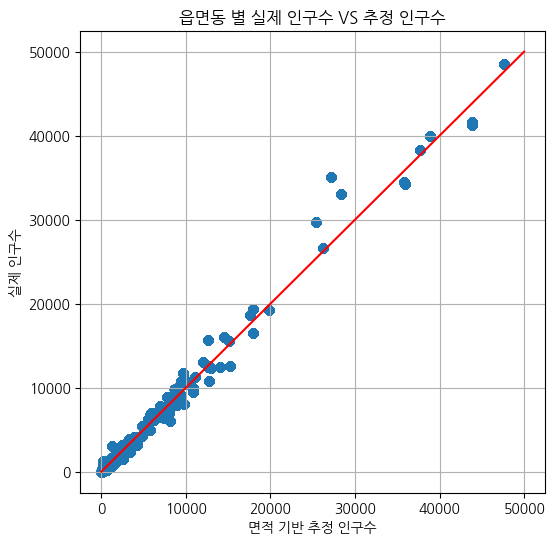

In [43]:
# 실제 인구수와 추정 인구수 비교 그래프
plt.figure(figsize=(6, 6))
plt.rc('font', family='NanumGothic')
plt.scatter(df_merged['읍면동리 추정 인구수'], df_merged['읍면동리 총인구'])

# y=x 선 그리기
plt.plot([0, 50000], [0, 50000], 'r')

plt.grid(True)
plt.title('읍면동 별 실제 인구수 VS 추정 인구수')
plt.xlabel('면적 기반 추정 인구수')
plt.ylabel('실제 인구수')
plt.show()

주택 면적으로 통해 예측한 추정 인구수가 실제 각 법정동의 총 인구수와 비슷하게 나타나는 것을 확인할 수 있다.

이는 읍면동 단위에선 주택 면적을 인구 분포의 지표로 쓸 수 있다는 것을 의미한다.

In [45]:
# 탐색 완료한 데이터 저장
df_merged.to_parquet('./data/jeonnam_pop.parquet')

---
---